In [703]:
import torch
import my_utils as mu
import pandas as pd
import torch.utils.data as data
from torch import nn
import numpy as np
from numpy import linalg

# Neural Networks ECS659P Revision Elliot Linsey

### Human Intelligence: 
* Skills - languages, chess, mathematical reasoning
* Cognition - perception, memory, judgement and reasoning
* Volition - The will, purpose, choice
* Emotion - affective intelligence
* Speed, efficiency and creativity of information processing

Still very far away from achieving a machine that contains these qualities! 

Gary Marcus - "Today's AI has been very successful in building systems that perform a single narrow goal extremely well!"

For example, playing chess or identifying dog breeds

### The Deep Learning Model

Similar in training to standard machine learning. We use labelled input training data to create predictions or classifications. 

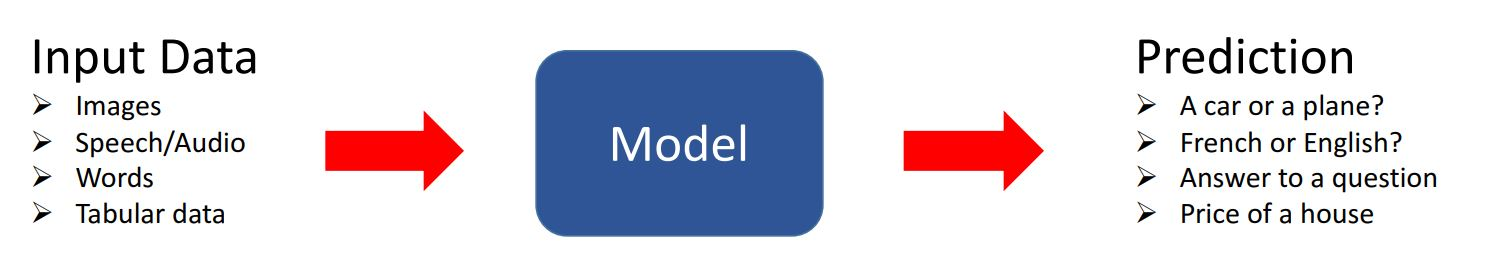

Within this, the model contains parameters (weights) which we compute functions or combinations of input data to make predictions

### Training the Model

We always start with random values for our parameters, then update them so that our model predictions are as **close as possible** to the real outputs. 

In [704]:
df = pd.read_csv('Fish.csv')
df = df.drop(columns='Species',axis=1)
df

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


In [705]:
df_zscore = (df - df.mean())/df.std()
df_zscore

,Weight,Length1,Length2,Length3,Height,Width
0,-0.436692,-0.304825,-0.281414,-0.105686,0.594700,-0.235784
1,-0.302606,-0.224797,-0.197430,-0.002329,0.818674,-0.066369
2,-0.162933,-0.234801,-0.178767,-0.010942,0.794830,0.165271
3,-0.098683,0.005285,0.054522,0.195772,0.877001,0.022550
4,0.088479,0.025292,0.054522,0.238837,0.810275,0.425028
...,...,...,...,...,...,...
154,-1.078631,-1.475242,-1.513179,-1.535458,-1.605287,-1.793735
155,-1.075279,-1.455235,-1.494516,-1.526845,-1.526056,-1.867646
156,-1.078631,-1.415221,-1.438527,-1.501006,-1.561752,-1.875476
157,-1.057680,-1.305181,-1.317216,-1.380422,-1.422748,-1.394163


In [706]:
feats_num = np.array(df_zscore.iloc[::,-2:].values)
labs_num = np.array(df_zscore.iloc[::,0].values)
#feats_num

In [707]:
A = np.column_stack([np.ones(len(df_zscore)),feats_num])
A

array([[ 1.        ,  0.59469968, -0.23578397],
       [ 1.        ,  0.8186739 , -0.06636925],
       [ 1.        ,  0.79482997,  0.16527098],
       [ 1.        ,  0.87700051,  0.02254976],
       [ 1.        ,  0.81027486,  0.42502837],
       [ 1.        ,  1.08053709,  0.30247556],
       [ 1.        ,  1.21517825,  0.51074415],
       [ 1.        ,  0.86300213,  0.16165253],
       [ 1.        ,  1.17444294,  0.25288497],
       [ 1.        ,  1.22616699,  0.3214576 ],
       [ 1.        ,  1.23461268,  0.40735134],
       [ 1.        ,  1.25994977,  0.23556386],
       [ 1.        ,  1.11711954, -0.02935427],
       [ 1.        ,  1.15297875,  0.38872521],
       [ 1.        ,  1.39596744,  0.44685772],
       [ 1.        ,  1.50879445,  0.68959058],
       [ 1.        ,  1.37403663,  0.51483715],
       [ 1.        ,  1.39214122,  0.46269586],
       [ 1.        ,  1.55428922,  0.42490973],
       [ 1.        ,  1.28384035,  0.77714525],
       [ 1.        ,  1.4365861 ,  0.683

In [708]:
true_w = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), labs_num)
true_w

array([-6.58327559e-16,  5.77667043e-02,  8.40704482e-01])

In [709]:
feats = torch.tensor(df_zscore.iloc[::,-2:].values).to(dtype=torch.float32)
labs = torch.tensor(df_zscore.iloc[::,0].values).to(dtype=torch.float32).reshape(159,1)
labs

tensor([[-0.4367],
        [-0.3026],
        [-0.1629],
        [-0.0987],
        [ 0.0885],
        [ 0.1443],
        [ 0.2840],
        [-0.0233],
        [ 0.1443],
        [ 0.2840],
        [ 0.2142],
        [ 0.2840],
        [ 0.2840],
        [-0.1629],
        [ 0.5634],
        [ 0.5634],
        [ 0.8427],
        [ 0.8427],
        [ 0.5913],
        [ 0.7030],
        [ 0.4935],
        [ 0.8008],
        [ 0.6192],
        [ 0.7868],
        [ 0.8427],
        [ 0.9126],
        [ 0.8986],
        [ 0.8818],
        [ 1.2617],
        [ 1.6808],
        [ 1.4573],
        [ 1.5550],
        [ 1.4712],
        [ 1.6109],
        [ 1.5411],
        [-1.0010],
        [-0.9200],
        [-0.8948],
        [-0.8697],
        [-0.7775],
        [-1.1127],
        [-0.8054],
        [-0.7775],
        [-0.6937],
        [-0.7077],
        [-0.6658],
        [-0.7216],
        [-0.6658],
        [-0.6406],
        [-0.6630],
        [-0.5540],
        [-0.6099],
        [-0.

In [710]:
dataset = data.TensorDataset(feats,labs)
train_iter, test_iter = data.random_split(dataset,[109,50],generator=torch.Generator().manual_seed(42))
batch_size = 20
train_iter,test_iter = data.DataLoader(train_iter,batch_size),data.DataLoader(test_iter,batch_size)
data_iter = data.DataLoader(dataset,batch_size)
print(dataset[0])

(tensor([ 0.5947, -0.2358]), tensor([-0.4367]))


In [711]:
next(iter(data_iter))


[tensor([[ 0.5947, -0.2358],
         [ 0.8187, -0.0664],
         [ 0.7948,  0.1653],
         [ 0.8770,  0.0225],
         [ 0.8103,  0.4250],
         [ 1.0805,  0.3025],
         [ 1.2152,  0.5107],
         [ 0.8630,  0.1617],
         [ 1.1744,  0.2529],
         [ 1.2262,  0.3215],
         [ 1.2346,  0.4074],
         [ 1.2599,  0.2356],
         [ 1.1171, -0.0294],
         [ 1.1530,  0.3887],
         [ 1.3960,  0.4469],
         [ 1.5088,  0.6896],
         [ 1.3740,  0.5148],
         [ 1.3921,  0.4627],
         [ 1.5543,  0.4249],
         [ 1.2838,  0.7771]]),
 tensor([[-0.4367],
         [-0.3026],
         [-0.1629],
         [-0.0987],
         [ 0.0885],
         [ 0.1443],
         [ 0.2840],
         [-0.0233],
         [ 0.1443],
         [ 0.2840],
         [ 0.2142],
         [ 0.2840],
         [ 0.2840],
         [-0.1629],
         [ 0.5634],
         [ 0.5634],
         [ 0.8427],
         [ 0.8427],
         [ 0.5913],
         [ 0.7030]])]

In [712]:
num_inputs,num_outputs = 2,1
net = nn.Linear(num_inputs,num_outputs)

In [713]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [714]:
net.apply(init_weights)

Linear(in_features=2, out_features=1, bias=True)

In [715]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.1)
loss = nn.MSELoss()
num_epochs=20

In [716]:
X,y = next(iter(data_iter))
X.shape
y.shape

torch.Size([20, 1])

In [717]:
for epoch in range(num_epochs):
    for X,y in data_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(feats),labs)
    print(f'epoch {epoch+1},loss {l:f}')

epoch 1,loss 0.283732
epoch 2,loss 0.274893
epoch 3,loss 0.264570
epoch 4,loss 0.259256
epoch 5,loss 0.256860
epoch 6,loss 0.255832
epoch 7,loss 0.255414
epoch 8,loss 0.255258
epoch 9,loss 0.255212
epoch 10,loss 0.255207
epoch 11,loss 0.255217
epoch 12,loss 0.255229
epoch 13,loss 0.255239
epoch 14,loss 0.255248
epoch 15,loss 0.255254
epoch 16,loss 0.255259
epoch 17,loss 0.255262
epoch 18,loss 0.255264
epoch 19,loss 0.255266
epoch 20,loss 0.255267


In [718]:
w=net.weight.data.reshape(-1)
b = net.bias.data
evals = torch.cat((b,w),0).numpy()
evals

array([ 0.15919816, -0.0102639 ,  0.76505923], dtype=float32)

In [719]:
true_w

array([-6.58327559e-16,  5.77667043e-02,  8.40704482e-01])

In [720]:
true_w-evals

array([-0.15919816,  0.06803061,  0.07564525])